In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic-dataset/Titanic-Dataset.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split,cross_val_score,LeaveOneOut
from sklearn.metrics import accuracy_score,make_scorer,f1_score,classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import scikitplot as skplt
import warnings
warnings.simplefilter(action='ignore')

**EDA**

In [3]:
df=pd.read_csv("/kaggle/input/titanic-dataset/Titanic-Dataset.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df.drop(["PassengerId","Name","Cabin","Ticket"],inplace=True,axis=1)

In [6]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df["Age"]=df["Age"].fillna(df["Age"].mean())

In [8]:
df.dropna(axis=0,inplace=True)

In [9]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [10]:
df["Embarked"].replace(["C","S","Q"],["Cherbourg","Southampton","Queenstown"])

0      Southampton
1        Cherbourg
2      Southampton
3      Southampton
4      Southampton
          ...     
886    Southampton
887    Southampton
888    Southampton
889      Cherbourg
890     Queenstown
Name: Embarked, Length: 889, dtype: object

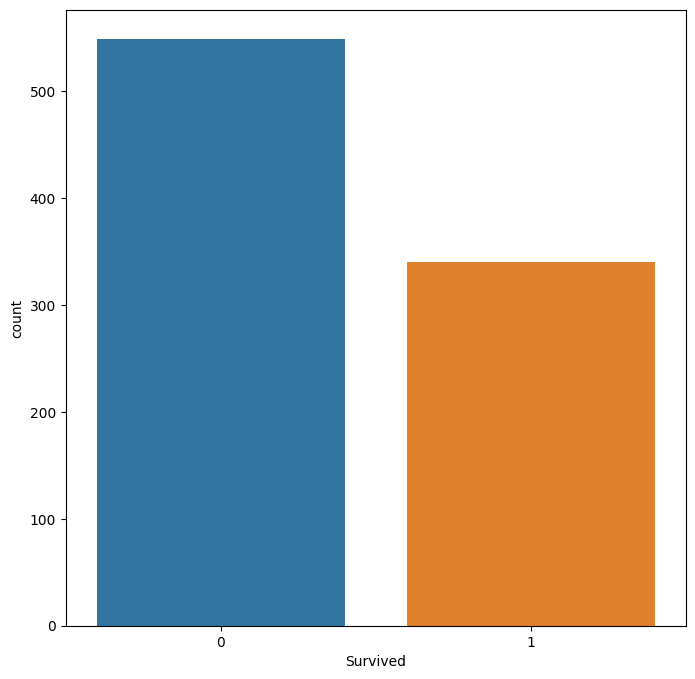

In [11]:
plt.figure(figsize=(8, 8))
sns.countplot(x="Survived",data=df)
plt.show()

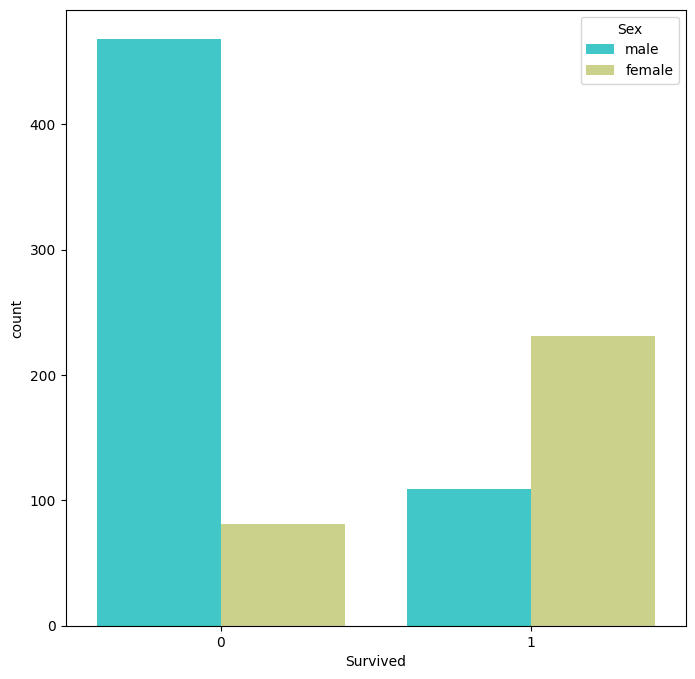

In [12]:
plt.figure(figsize=(8, 8))
sns.countplot(x="Survived",data=df, hue="Sex",palette="rainbow")
plt.show()

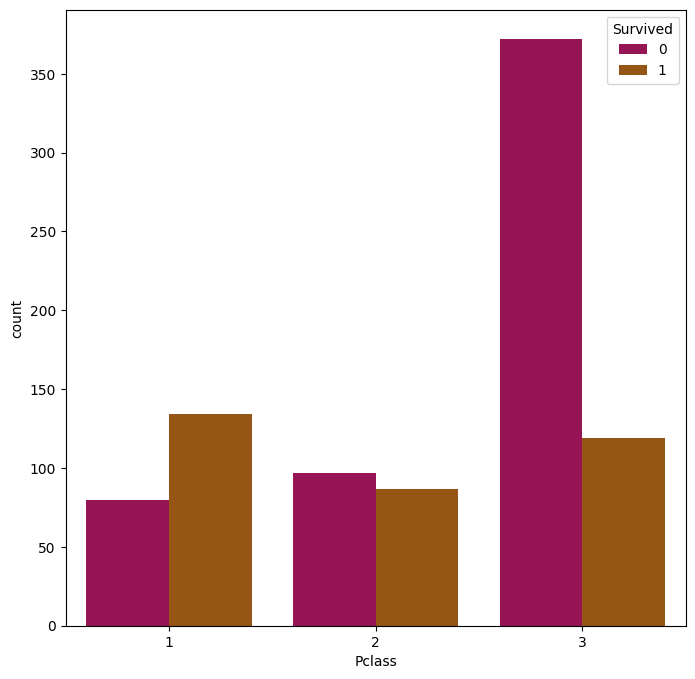

In [13]:
plt.figure(figsize=(8, 8))
sns.countplot(x="Pclass",data=df, hue="Survived",palette="brg")
plt.show()

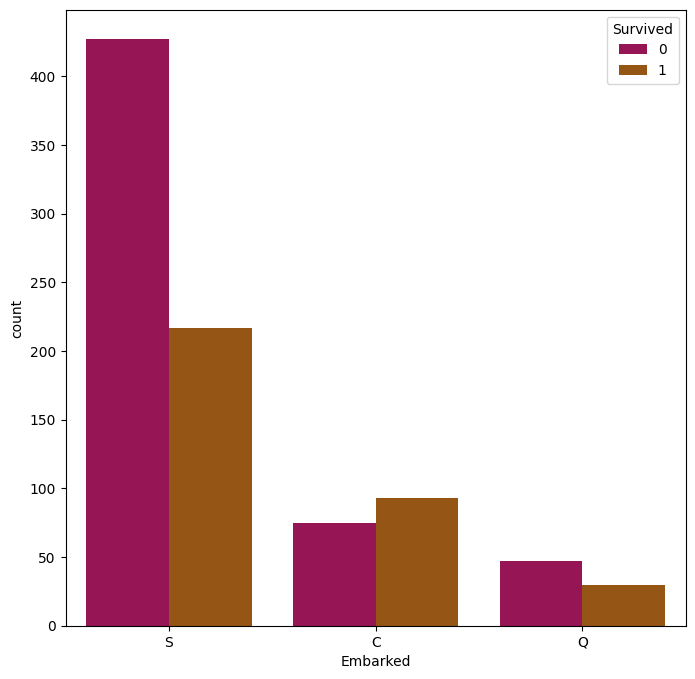

In [14]:
plt.figure(figsize=(8, 8))
sns.countplot(x="Embarked",data=df, hue="Survived",palette="brg")
plt.show()

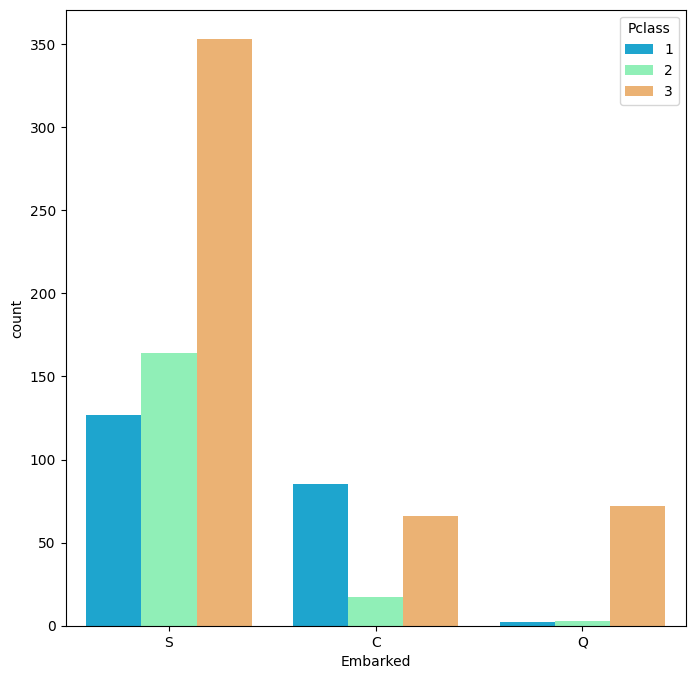

In [15]:
plt.figure(figsize=(8, 8))
sns.countplot(x="Embarked",data=df, hue="Pclass",palette="rainbow")
plt.show()

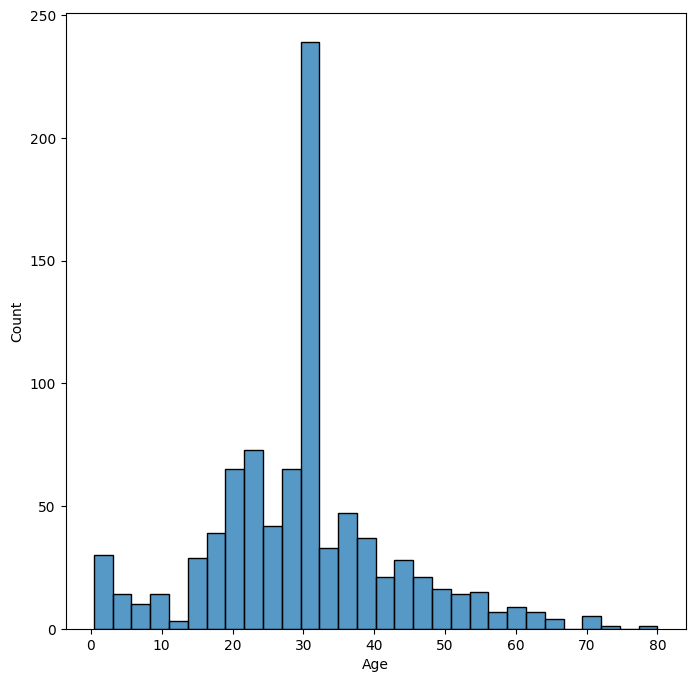

In [16]:
plt.figure(figsize=(8, 8))
sns.histplot(x="Age",data=df,palette="rainbow")
plt.show()

In [17]:
df=pd.get_dummies(df,["sex","Embarked"])

In [18]:
df

,Survived,Pclass,Age,SibSp,Parch,Fare,sex_female,sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.000000,1,0,7.2500,False,True,False,False,True
1,1,1,38.000000,1,0,71.2833,True,False,True,False,False
2,1,3,26.000000,0,0,7.9250,True,False,False,False,True
3,1,1,35.000000,1,0,53.1000,True,False,False,False,True
4,0,3,35.000000,0,0,8.0500,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.000000,0,0,13.0000,False,True,False,False,True
887,1,1,19.000000,0,0,30.0000,True,False,False,False,True
888,0,3,29.699118,1,2,23.4500,True,False,False,False,True
889,1,1,26.000000,0,0,30.0000,False,True,True,False,False


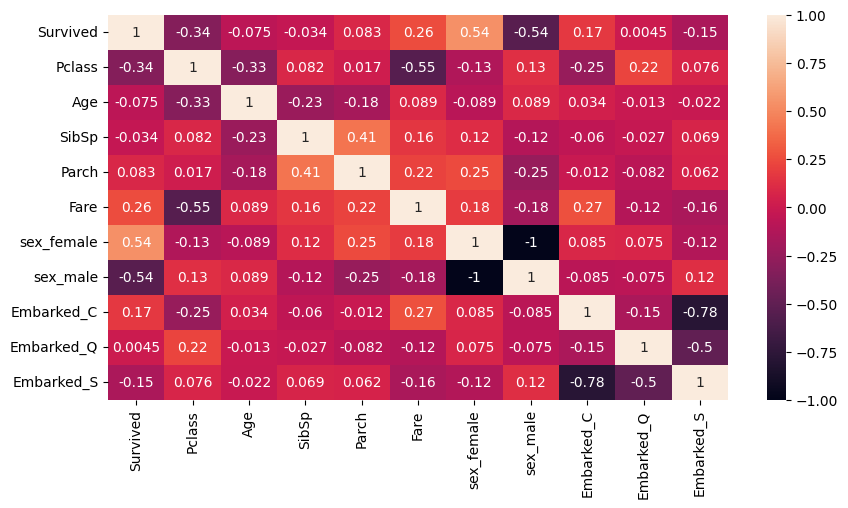

In [19]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(),annot=True)
plt.show()

In [20]:
X=df.drop("Survived",axis=1)
y=df["Survived"]

In [21]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.3,stratify=y,random_state=0)

**EXTRA TREES**

In [22]:
ex=ExtraTreesClassifier(n_estimators=110,max_depth=12,random_state=0)
scores=cross_val_score(ex,X_train,y_train,cv=LeaveOneOut(),n_jobs=-1,scoring=make_scorer(f1_score,average="micro"))
print(scores.mean(),scores.std())

0.7958199356913184 0.40310118537109796


In [23]:
ex.fit(X_train,y_train)

ExtraTreesClassifier(max_depth=12, n_estimators=110, random_state=0)

In [24]:
pre=ex.predict(X_test)
print(f1_score(y_test,pre,average="micro"))

0.842696629213483


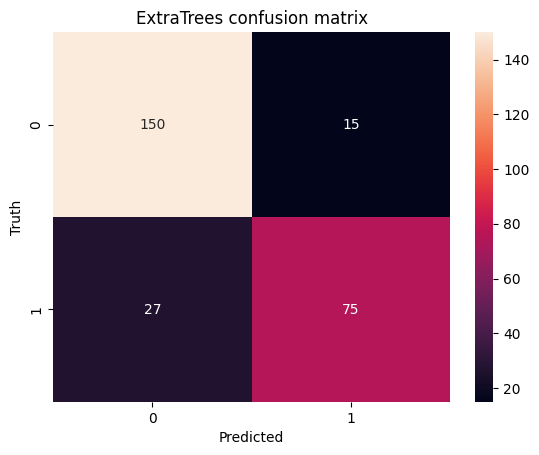

In [25]:
cm = skplt.metrics.confusion_matrix(y_test, pre)
sns.heatmap(cm, annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title(f"ExtraTrees confusion matrix")
plt.show()

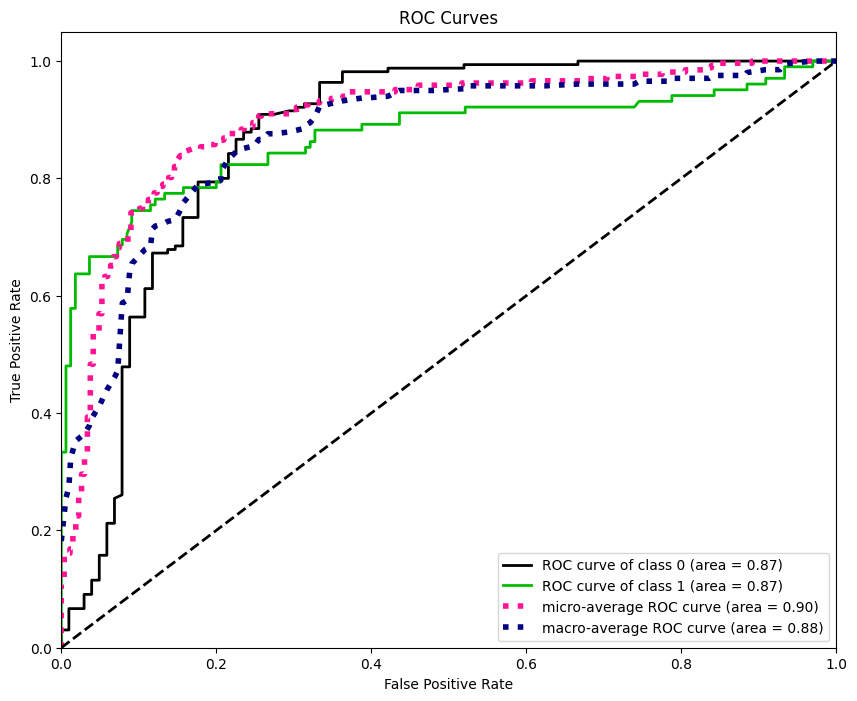

In [26]:
skplt.metrics.plot_roc(y_test,ex.predict_proba(X_test),figsize=(10,8))
plt.show()

**GradientBoosting**

In [27]:
gb=GradientBoostingClassifier(n_estimators=50,max_depth=5)
scores=cross_val_score(gb,X_train,y_train,cv=LeaveOneOut(),n_jobs=-1,scoring=make_scorer(f1_score,average="micro"))
print(scores.mean(),scores.std())

0.8086816720257235 0.39333907173760874


In [28]:
gb.fit(X_train,y_train)

GradientBoostingClassifier(max_depth=5, n_estimators=50)

In [29]:
pre_gb=gb.predict(X_test)
print(f1_score(y_test,pre_gb,average="micro"))

0.8726591760299626


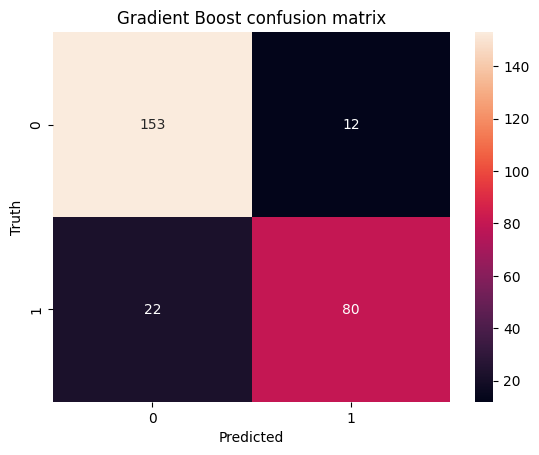

In [30]:
cm = skplt.metrics.confusion_matrix(y_test, pre_gb)
sns.heatmap(cm, annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title(f"Gradient Boost confusion matrix")
plt.show()



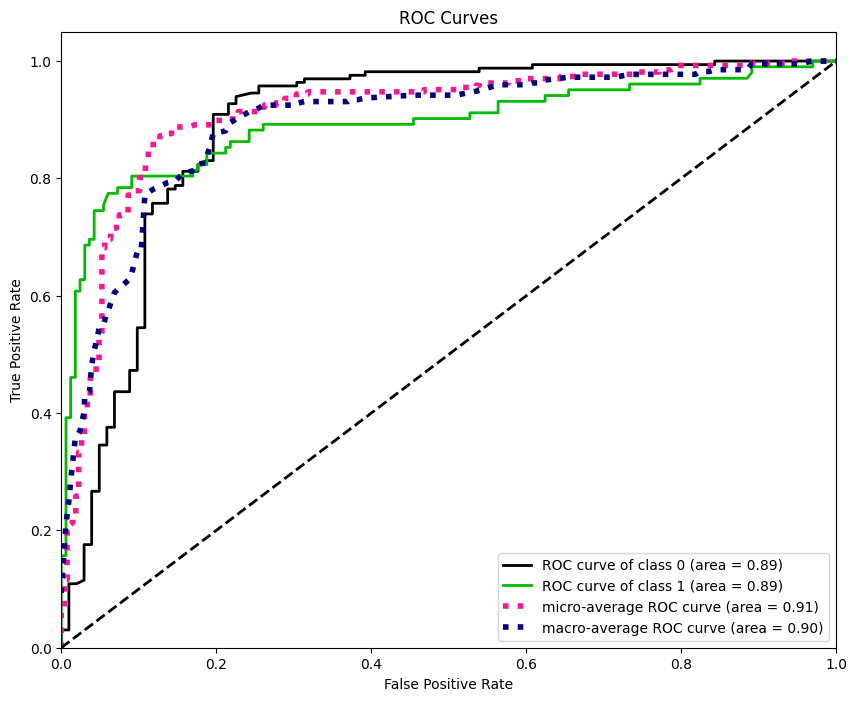

In [31]:
skplt.metrics.plot_roc(y_test,gb.predict_proba(X_test),figsize=(10,8))
plt.show()

**LogisticRegression**

In [32]:
lr=LogisticRegression(max_iter=2000,C=1)
scores=cross_val_score(lr,X_train,y_train,cv=LeaveOneOut(),n_jobs=-1,scoring=make_scorer(f1_score,average="micro"))
print(scores.mean(),scores.std())

0.7845659163987139 0.41112314362507035


In [33]:
lr.fit(X_train,y_train)

LogisticRegression(C=1, max_iter=2000)

In [34]:
pre_lr=lr.predict(X_test)
print(f1_score(y_test,pre_lr,average="micro"))

0.8164794007490637


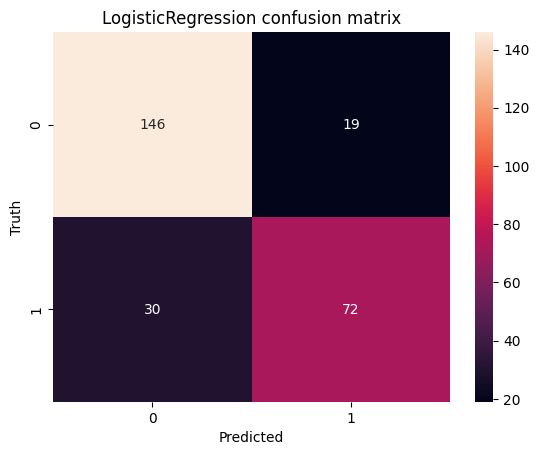

In [35]:
cm = skplt.metrics.confusion_matrix(y_test, pre_lr)
sns.heatmap(cm, annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title(f"LogisticRegression confusion matrix")
plt.show()

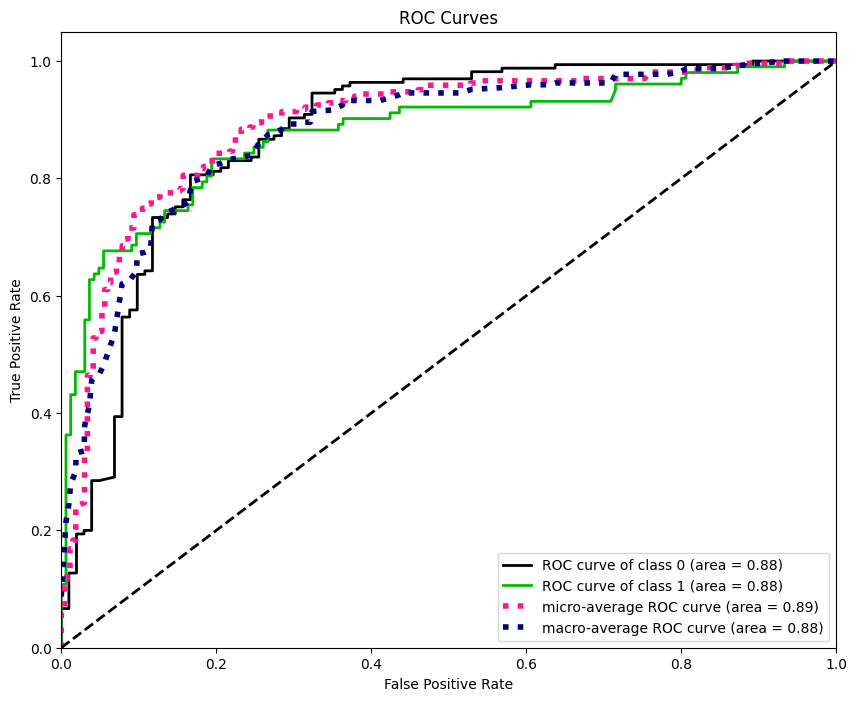

In [36]:
skplt.metrics.plot_roc(y_test,lr.predict_proba(X_test),figsize=(10,8))
plt.show()

In [37]:
#no of surival people
survived_counts = df['Survived'].value_counts()
survived_counts

Survived
0    549
1    340
Name: count, dtype: int64

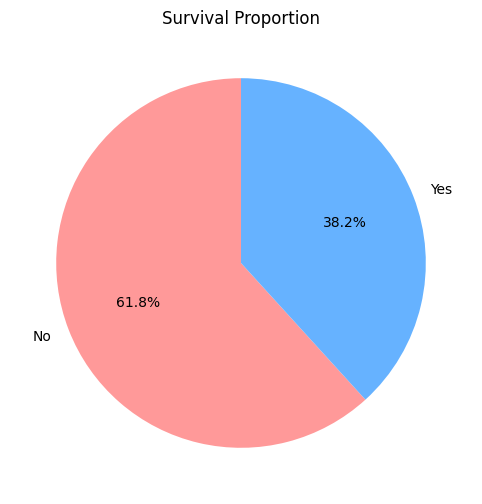

In [38]:
# let us know visulize the survial rate 
plt.figure(figsize=(8, 6))
plt.pie(survived_counts, labels=['No', 'Yes'], autopct='%1.1f%%', colors=['#FF9999', '#66B2FF'], startangle=90)
plt.title('Survival Proportion')
plt.show()

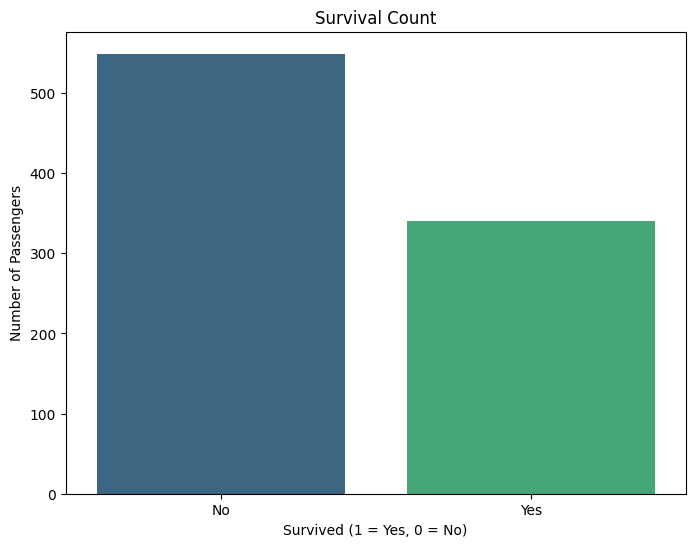

In [39]:
#let us visulize using the other tool i.e bargraph
plt.figure(figsize=(8, 6))
sns.barplot(x=survived_counts.index, y=survived_counts.values, palette='viridis')
plt.title('Survival Count')
plt.xlabel('Survived (1 = Yes, 0 = No)')
plt.ylabel('Number of Passengers')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

In [40]:
import pandas as pd
data=pd.read_csv("/kaggle/input/titanic-dataset/Titanic-Dataset.csv")

In [41]:
#let find no of mens and women travelled in the ship
data.Sex.value_counts()


Sex
male      577
female    314
Name: count, dtype: int64

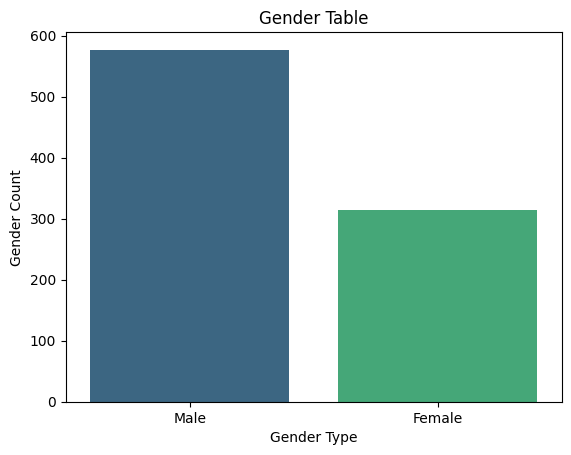

In [42]:
#let us visulize the sex ratio in the bargraph
sns.barplot(x=['Male','Female'],y=data.Sex.value_counts(),palette='viridis')
plt.title("Gender Table")
plt.xlabel('Gender Type')
plt.ylabel('Gender Count')
plt.show()

In [43]:
# let us describe the age of the persons travelling in the ship
data.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

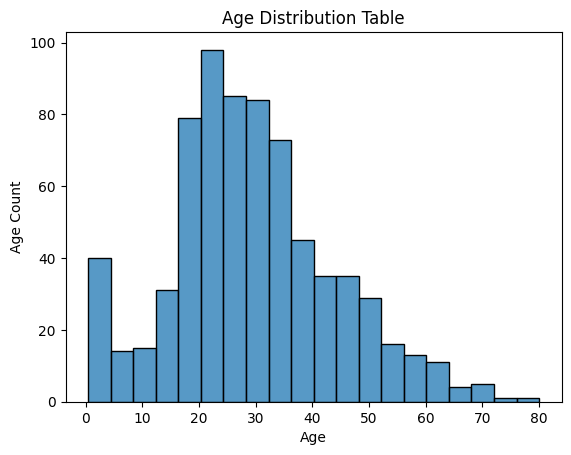

In [44]:
#let us visulize using the age category
sns.histplot(x=data['Age'],bins=20)
plt.title("Age Distribution Table")
plt.xlabel("Age")
plt.ylabel('Age Count')
plt.show()

In [45]:
# there is anyother catory which is realted to no siblings travelled along with them in the ship
print(data.SibSp.value_counts())


SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64


Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64


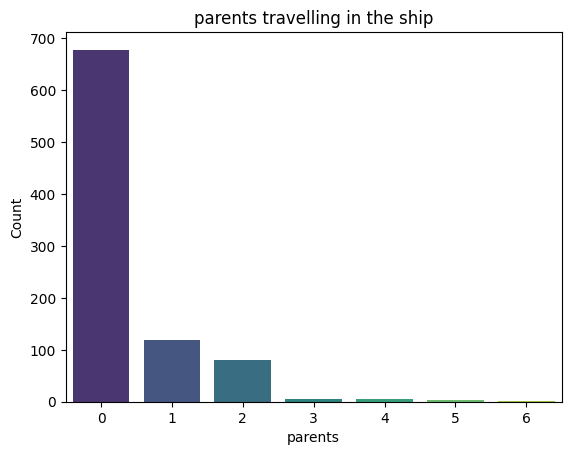

In [46]:
print(data.Parch.value_counts())

sns.barplot(x=['0','1','2','3','4','5','6'],y=data.Parch.value_counts(),palette='viridis')
plt.title("parents travelling in the ship")
plt.xlabel('parents')
plt.ylabel('Count')
plt.show()

In [47]:
data.groupby(['Sex'])['Survived'].value_counts()

Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: count, dtype: int64

In [48]:
data.groupby(['Pclass'])['Survived'].value_counts()

Pclass  Survived
1       1           136
        0            80
2       0            97
        1            87
3       0           372
        1           119
Name: count, dtype: int64

In [49]:
data.groupby(['Pclass','Sex'])['Survived'].value_counts()

Pclass  Sex     Survived
1       female  1            91
                0             3
        male    0            77
                1            45
2       female  1            70
                0             6
        male    0            91
                1            17
3       female  0            72
                1            72
        male    0           300
                1            47
Name: count, dtype: int64

In [50]:
data[data['Survived']==0].groupby(['Age'])['Survived'].value_counts()


Age   Survived
1.0   0           2
2.0   0           7
3.0   0           1
4.0   0           3
6.0   0           1
                 ..
66.0  0           1
70.0  0           2
70.5  0           1
71.0  0           2
74.0  0           1
Name: count, Length: 77, dtype: int64

In [51]:
data.groupby(['Age','Sex'])['Survived'].value_counts()

Age    Sex     Survived
0.42   male    1           1
0.67   male    1           1
0.75   female  1           2
0.83   male    1           2
0.92   male    1           1
                          ..
70.00  male    0           2
70.50  male    0           1
71.00  male    0           2
74.00  male    0           1
80.00  male    1           1
Name: count, Length: 216, dtype: int64

In [52]:
data.groupby(['SibSp'])['Survived'].value_counts()

SibSp  Survived
0      0           398
       1           210
1      1           112
       0            97
2      0            15
       1            13
3      0            12
       1             4
4      0            15
       1             3
5      0             5
8      0             7
Name: count, dtype: int64

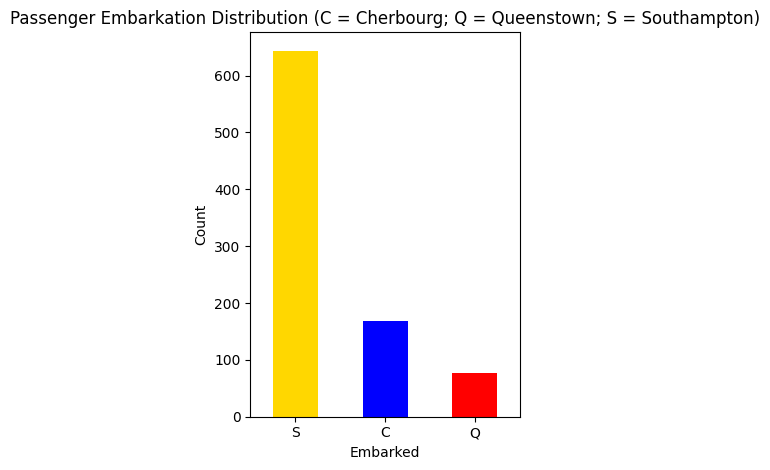

In [53]:
plt.subplot(1, 2, 2)
data['Embarked'].value_counts().plot(kind='bar', color=['gold', 'blue', 'red'])
plt.title('Passenger Embarkation Distribution (C = Cherbourg; Q = Queenstown; S = Southampton)')
plt.xlabel('Embarked')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119


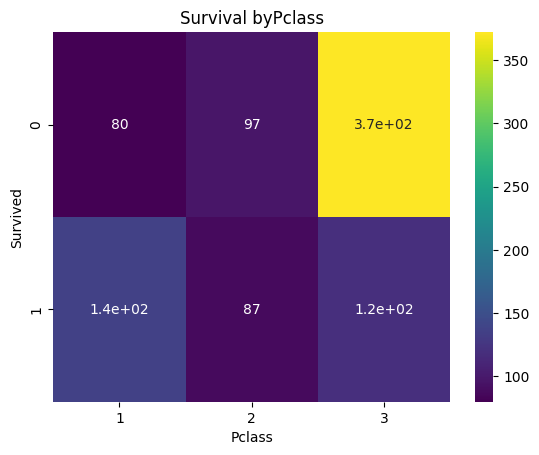

In [54]:
tab = pd.crosstab(data['Survived'], data['Pclass'])

print(tab)
sns.heatmap(tab, annot=True, cmap='viridis')
plt.title('Survival byPclass')
plt.show()

> let us do some other machine learning models to predict the survail rate of the person travelling in the ship 
 ->

In [55]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score


In [56]:

svc=SVC()
rfc=RandomForestClassifier()
knn=KNeighborsClassifier()
dtc=DecisionTreeClassifier()

In [57]:
#lets train the data by SVC
svc.fit(X_train,y_train)
y_predit = svc.predict(X_test)
svc_acc = f"{accuracy_score(y_test, y_predit) * 100:.2f}%"
print("Accuracy:",svc_acc)
print(confusion_matrix(y_test,y_predit))
svc_pscore = f" {precision_score(y_test,y_predit)* 100:.2f}%"
print("P_Score:",svc_pscore)

Accuracy: 67.79%
[[149  16]
 [ 70  32]]
P_Score:  66.67%


In [58]:
#lets train the data by RFC
rfc.fit(X_train,y_train)
y_predit = rfc.predict(X_test)
rfc_acc = f"{accuracy_score(y_test, y_predit) * 100:.2f}%"
print("Accuracy:",rfc_acc)
print(confusion_matrix(y_test,y_predit))
rfc_pscore = f" {precision_score(y_test,y_predit)* 100:.2f}%"
print("P_Score:",rfc_pscore)

Accuracy: 82.77%
[[145  20]
 [ 26  76]]
P_Score:  79.17%


In [59]:
#lets train the data by knn
knn.fit(X_train,y_train)
y_predit = knn.predict(X_test)
knn_acc = f"{accuracy_score(y_test, y_predit) * 100:.2f}%"
print("Accuracy:",knn_acc)
print(confusion_matrix(y_test,y_predit))
knn_pscore = f" {precision_score(y_test,y_predit)* 100:.2f}%"
print("P_Score:",knn_pscore)


Accuracy: 76.03%
[[140  25]
 [ 39  63]]
P_Score:  71.59%


In [60]:
#lets train the data by DTC
dtc.fit(X_train,y_train)
y_predit = dtc.predict(X_test)
dtc_acc = f"{accuracy_score(y_test, y_predit) * 100:.2f}%"
print("Accuracy:",dtc_acc)
print(confusion_matrix(y_test,y_predit))
dtc_pscore = f" {precision_score(y_test,y_predit)* 100:.2f}%"
print("P_Score:",dtc_pscore)

Accuracy: 81.65%
[[139  26]
 [ 23  79]]
P_Score:  75.24%
